# Statistical analysis of the distributions obtained by MCMC and GFN

We are going to split the document in two main categories following the classification in this [link](https://towardsdatascience.com/how-to-compare-two-or-more-distributions-9b06ee4d30bf): visualization and quantitative analysis.

In [1]:
import os
import sys

ROOT_DIR = os.path.abspath("__file__" + "/../../")
sys.path.insert(0, f"{ROOT_DIR}")

In [2]:
import seaborn as sns
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tableone
import statsmodels

## Importing data and preparing the dataframes

### Importing data

In [3]:
import numpy as np

spin_j = 6

env_name = f"single vertex spinfoam/j={float(spin_j)}"
batch_size = 16
n_iterations = int(1e5)

vertex = np.load(f"{ROOT_DIR}/data/EPRL_vertices/Python/Dl_20/vertex_j_{float(spin_j)}.npz")
sq_ampl = vertex**2
grid_rewards = sq_ampl / np.sum(sq_ampl)

grid_len = int(2*spin_j + 1)

In [4]:
gfn_states = np.load(f"{ROOT_DIR}/data/GFN/single vertex spinfoam/j={float(spin_j)}/terminal_states.npy")

In [112]:
def get_distributions_over_time(grid_positions, grid_len, every_n_iterations=100):
    n_iterations, _, grid_dim = grid_positions.shape

    counts = np.zeros(shape=(grid_len, )*grid_dim)
    n_samples = 0
    empirical_distributions_over_time = []
    n_samples_used_over_time = []
    for i in range(0, n_iterations, every_n_iterations):
        states = np.concatenate(grid_positions[i:i+every_n_iterations])

        n_samples += states.shape[0]
        np.add.at(counts, tuple(states.T), 1)
        
        empirical_distributions_over_time.append(counts/n_samples)
        n_samples_used_over_time.append(n_samples)
    empirical_distributions_over_time = np.stack(empirical_distributions_over_time)
    return empirical_distributions_over_time, n_samples_used_over_time

def get_distributions_over_time_flattened(grid_len, distributions_over_time, iteration = -1):
    distributions_over_time_flattened = []
    grid_coordinates = []
    for i1 in range(grid_len):
        for i2 in range(grid_len):
            for i3 in range(grid_len):
                for i4 in range(grid_len):
                    for i5 in range(grid_len):
                        if len(distributions_over_time.shape) == 6:
                            distributions_over_time_flattened.append(distributions_over_time[iteration, i1, i2, i3, i4, i5])
                        elif len(distributions_over_time.shape) == 5:
                            distributions_over_time_flattened.append(distributions_over_time[i1, i2, i3, i4, i5])
                       
                        grid_coordinates.append(f"{int(i1)}, {int(i2)}, {int(i3)}, {int(i4)}, {int(i5)}")

    return grid_coordinates, np.array(distributions_over_time_flattened)



In [40]:
gfn_states = np.load(f"{ROOT_DIR}/data/GFN/single vertex spinfoam/j={float(spin_j)}/terminal_states.npy")

gfn_distributions_over_time, gfn_n_t = get_distributions_over_time(
    gfn_states, grid_len, every_n_iterations=100
)

In [41]:
mcmc_chains = np.load(f"{ROOT_DIR}/data/MCMC/single vertex spinfoam/j={float(spin_j)}/mcmc_chains.npy")
mcmc_distributions_over_time, mcmc_n_t = get_distributions_over_time(
    mcmc_chains, grid_len, every_n_iterations=100, 
)

### Building dataframes

In [113]:
# Create a 2D array of the grid coordinates and the respective rewards, flattened.
grid_coordinates_list, gfn_distributions_over_time_flattened = get_distributions_over_time_flattened(grid_len, gfn_distributions_over_time)

grid_coordinates_list, mcmc_distributions_over_time_flattened = get_distributions_over_time_flattened(grid_len, mcmc_distributions_over_time)

_, theoretical_distributions_over_time_flattened = get_distributions_over_time_flattened(grid_len, grid_rewards)


In [44]:
df = pd.DataFrame({"Grid Coordinate": grid_coordinates_list, "Theoretical": theoretical_distributions_over_time_flattened, "MCMC": mcmc_distributions_over_time_flattened, "GFN": gfn_distributions_over_time_flattened})

In [111]:
distributions_list = []

for i in range(len(mcmc_distributions_over_time_flattened)):
    distributions_list.append("Theoretical")

for i in range(len(mcmc_distributions_over_time_flattened)):
    distributions_list.append("MCMC")

for i in range(len(gfn_distributions_over_time_flattened)):
    distributions_list.append("GFN")

In [ ]:
df_new = df = pd.DataFrame({"Grid Coordinate": grid_coordinates_list, "Theoretical": theoretical_distributions_over_time_flattened, "MCMC": mcmc_distributions_over_time_flattened, "GFN": gfn_distributions_over_time_flattened})

## Visualization

### Boxplot

For the box plot, we can have in the x-axis the theoretical distribution along with the empirical ones and in the y the respective frequencies for the grid coordinates. We can, then, check whether the simualtions overestimate grid coordinated in general or if they follow a more "smooth" distibution.

In [10]:
# Assuming a pd dataframe with three columns distribution type, grid coordinates, frequency/reward and as number of rows 3*number of ccordinates

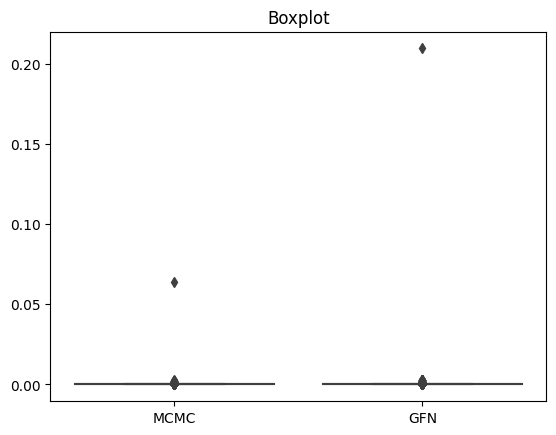

<Figure size 640x480 with 0 Axes>

In [51]:
sns.boxplot(data=df[["MCMC", "GFN"]], order=["MCMC", "GFN"])
plt.title("Boxplot")
plt.show()
plt.clf()


### Histrogram

The same applies for the histrogram. Three histograms (one for each distribution) one on top of the other where we plot the respective frequencies/rewards for each grid ccordinate.

<Axes: >

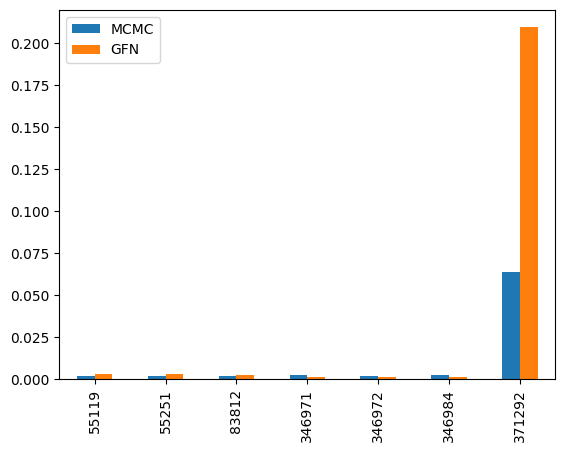

In [34]:
df[df.MCMC > 0.002].plot(kind='bar')

In [118]:
int(gfn_states.shape[0]/10)
gfn_states.shape[0]

100000

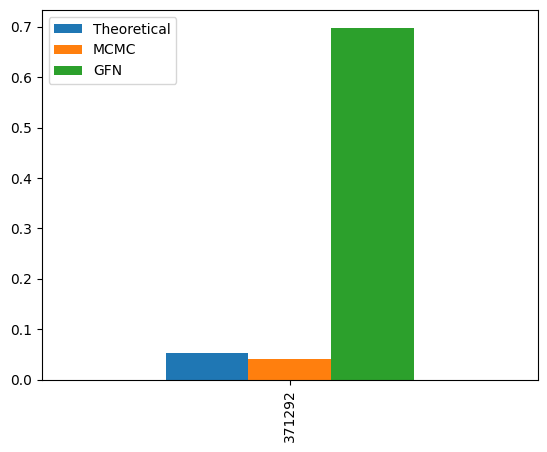

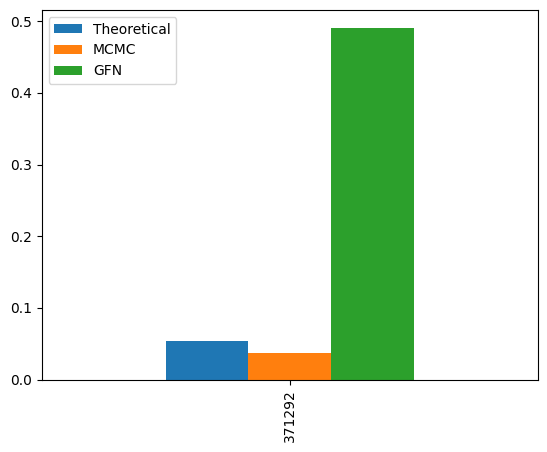

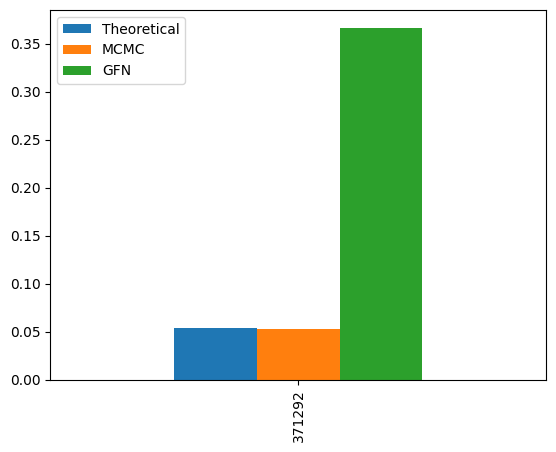

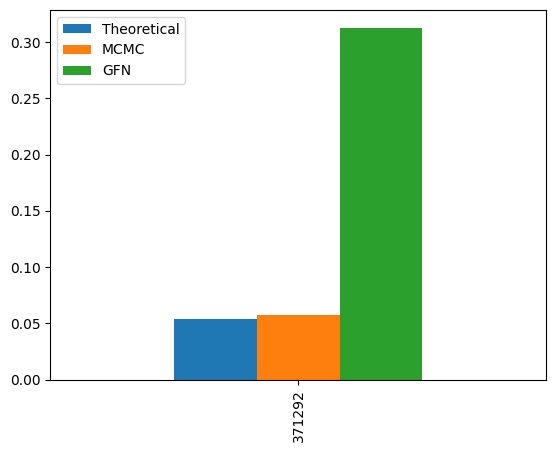

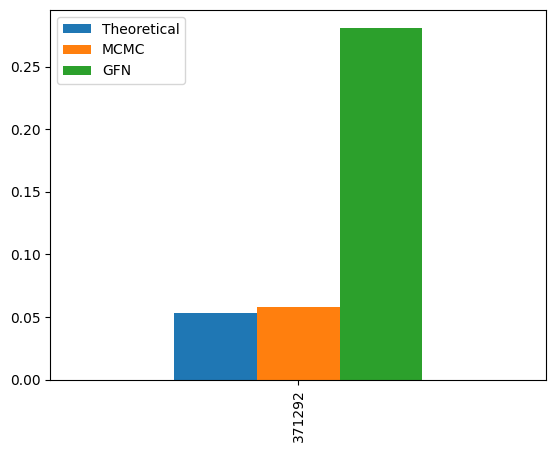

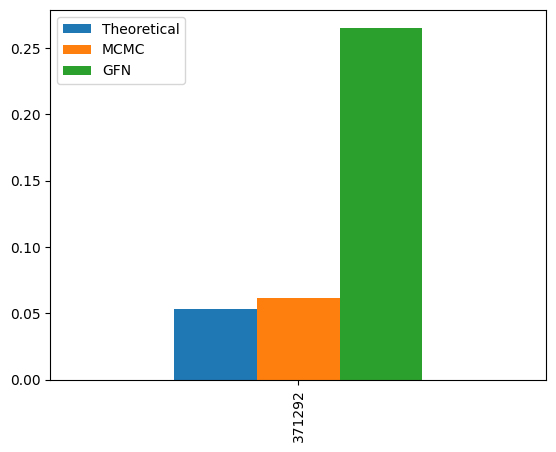

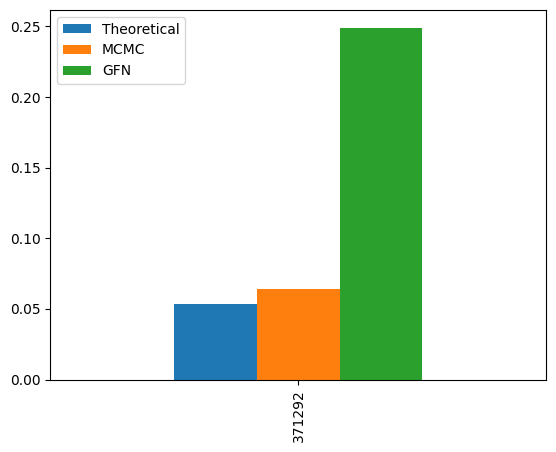

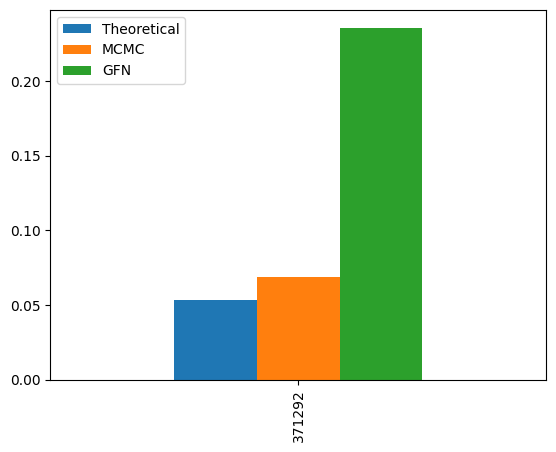

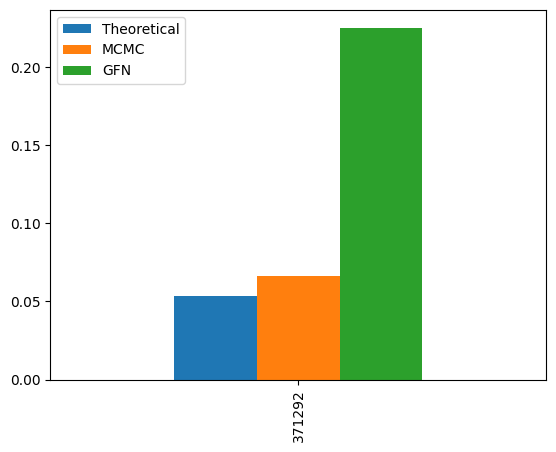

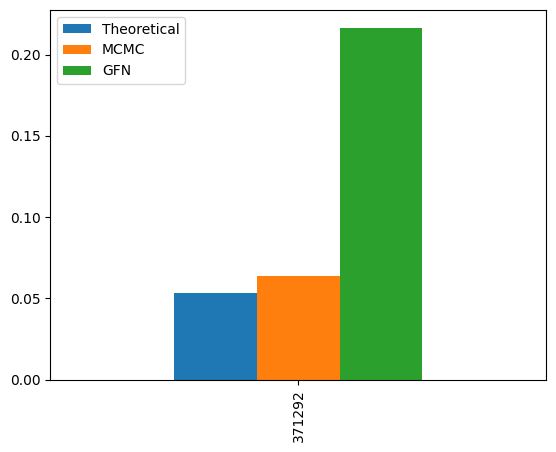

In [120]:
for i in range(0, gfn_distributions_over_time.shape[0], int(gfn_distributions_over_time.shape[0]/10)):
    _, gfn_distributions_over_time_flattened_batch = get_distributions_over_time_flattened(grid_len, gfn_distributions_over_time, iteration=i)
    _, mcmc_distributions_over_time_flattened_batch = get_distributions_over_time_flattened(grid_len, mcmc_distributions_over_time, iteration=i)
    df_batch = pd.DataFrame({"Grid Coordinate": grid_coordinates_list, "Theoretical": theoretical_distributions_over_time_flattened, "MCMC": mcmc_distributions_over_time_flattened_batch, "GFN": gfn_distributions_over_time_flattened_batch})
    df_batch[df_batch.MCMC > 0.02].plot(kind='bar')

### Kernel Density (DON'T KNOW IF WE ACTUALLY NEED IT)

The same with the histogram but in a continous approximation.

<Axes: ylabel='Density'>

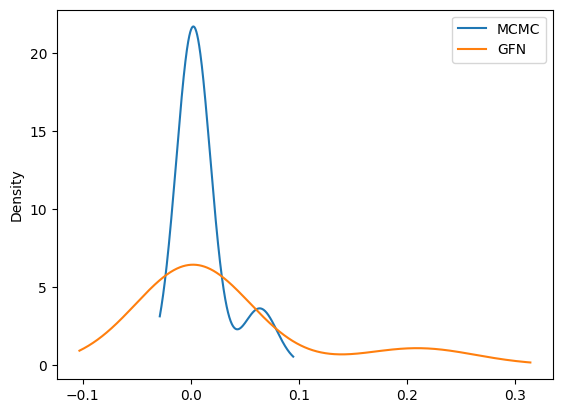

In [35]:
df[df.MCMC > 0.002].plot.kde()

In [ ]:
sns.kdeplot(x='Grid Coordinate', data=df, hue='Distribution', common_norm=False)
plt.title("Kernel Density Function")
plt.show()
plt.clf()

### Cumulative Distributions (DATASET IS TOO BIG FOR A CONTINUOUS PLOT)

The same as in the histogram but for a contunuous cunulative distribution.

In [ ]:
sns.histplot(x='Grid Coordinate', data=df, hue='Distribution', bins=len(df), stat="density",
             element="step", fill=False, cumulative=True, common_norm=False)
plt.title("Cumulative distribution function")
plt.show()
plt.clf()


### Q-Q Plot

Here we are going to have two plots. One for the MCMC with respect to the theoretical one and one with GFN with respect to the theoretical one.

In [55]:
grid_coordinates = df[['Grid Coordinate']].values
grid_coordinates_theoretical = df[["Theoretical"]].values
grid_coordinates_MCMC = df[["MCMC"]].values
grid_coordinates_GFN = df[["GFN"]].values

df_pct = pd.DataFrame()
df_pct['q_theoretical'] = np.percentile(grid_coordinates_theoretical, range(100))
df_pct['q_MCMC'] = np.percentile(grid_coordinates_MCMC, range(100))
df_pct['q_GFN'] = np.percentile(grid_coordinates_GFN, range(100))

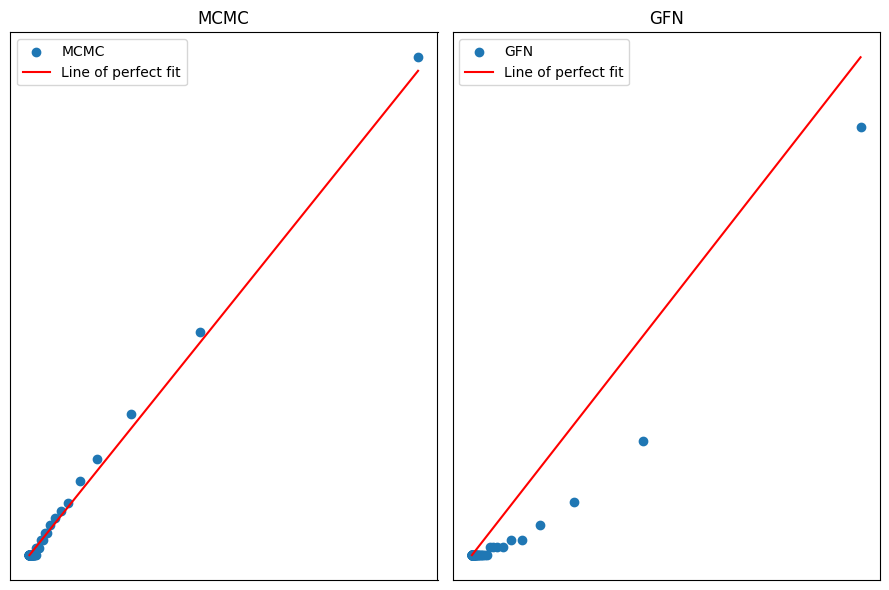

<Figure size 640x480 with 0 Axes>

In [56]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 6), subplot_kw={'xticks': [], 'yticks': []})

axs[0].scatter(x='q_theoretical', y='q_MCMC', data=df_pct, label='MCMC')
sns.lineplot(ax=axs[0], x='q_theoretical', y='q_theoretical', data=df_pct, color='r', label='Line of perfect fit')
axs[0].set_title("MCMC")
axs[1].scatter(x='q_theoretical', y='q_GFN', data=df_pct, label='GFN')
sns.lineplot(ax=axs[1], x='q_theoretical', y='q_theoretical', data=df_pct, color='r', label='Line of perfect fit')
axs[1].set_title("GFN")

plt.tight_layout()
plt.show()
plt.clf()


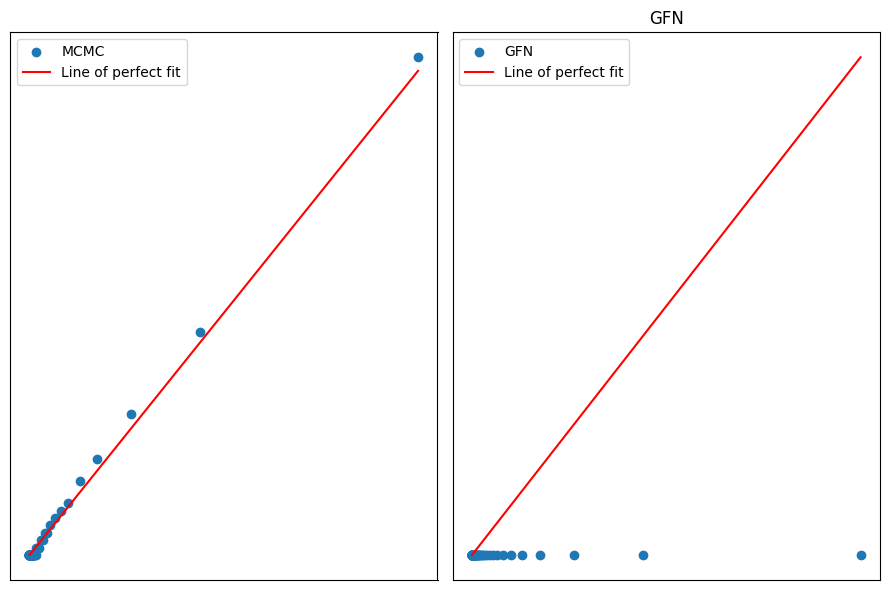

<Figure size 640x480 with 0 Axes>

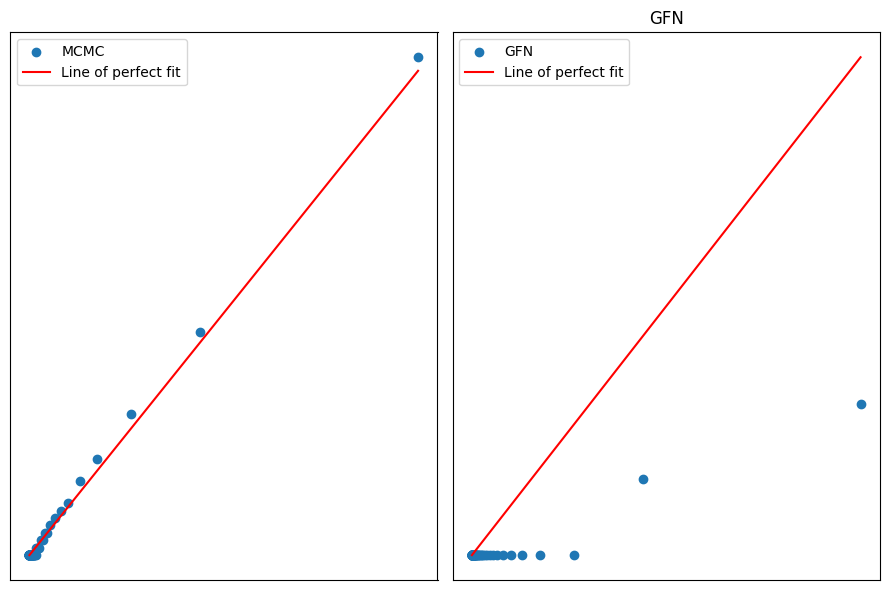

<Figure size 640x480 with 0 Axes>

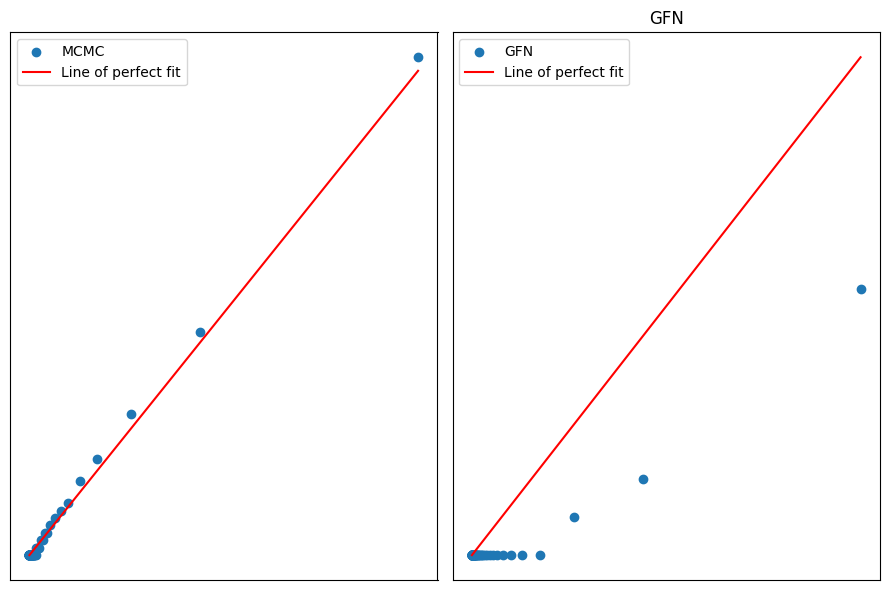

<Figure size 640x480 with 0 Axes>

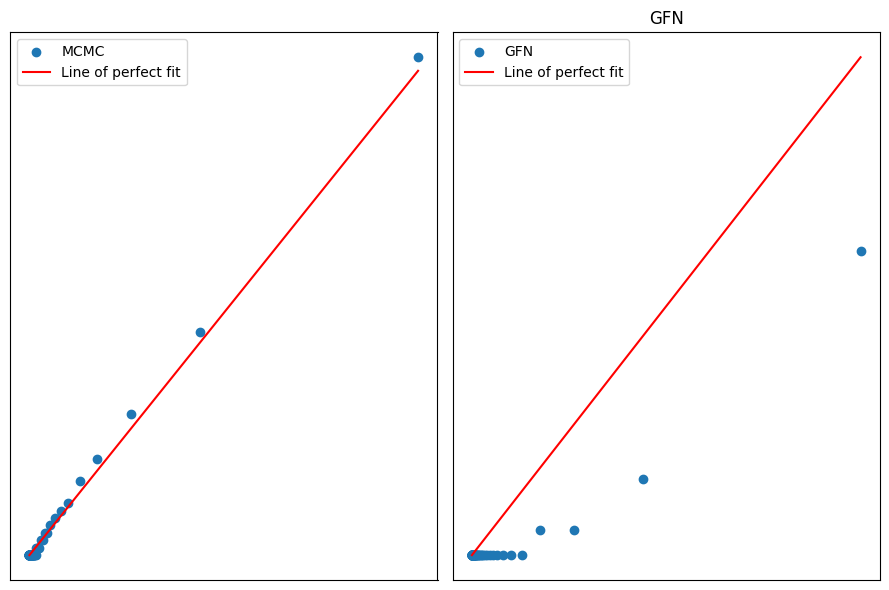

<Figure size 640x480 with 0 Axes>

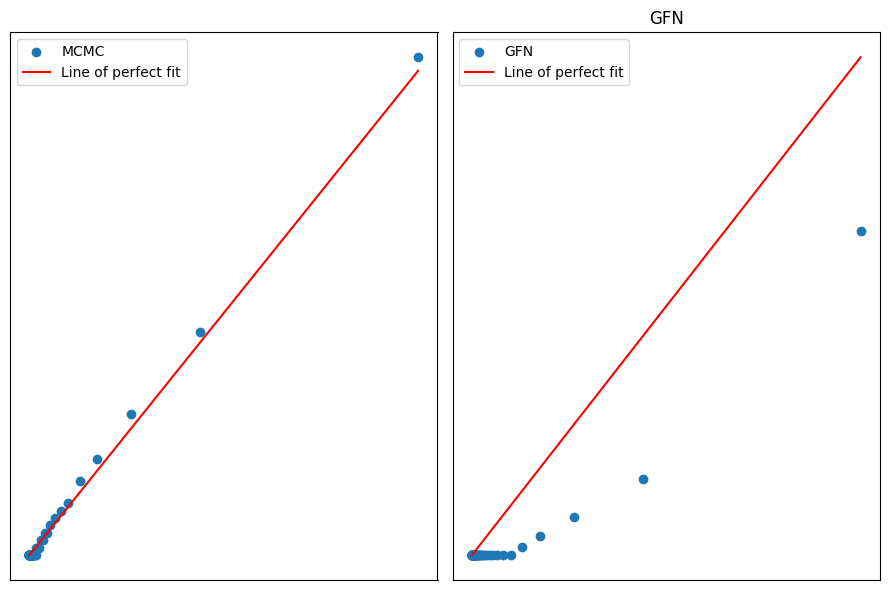

<Figure size 640x480 with 0 Axes>

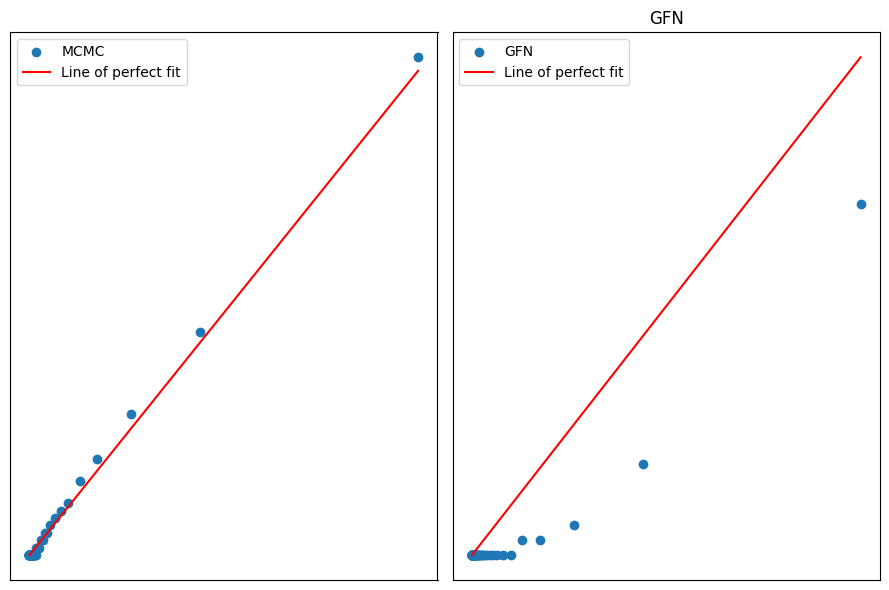

<Figure size 640x480 with 0 Axes>

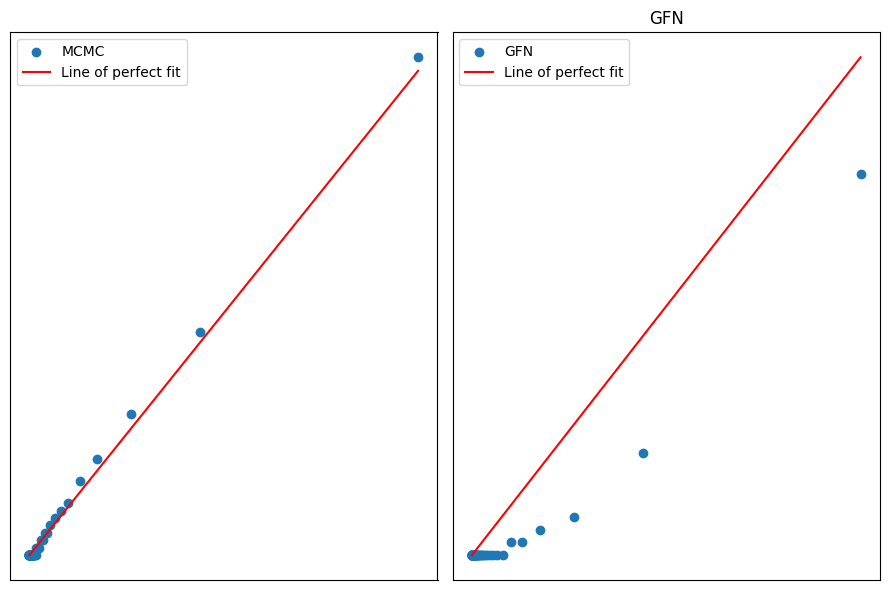

<Figure size 640x480 with 0 Axes>

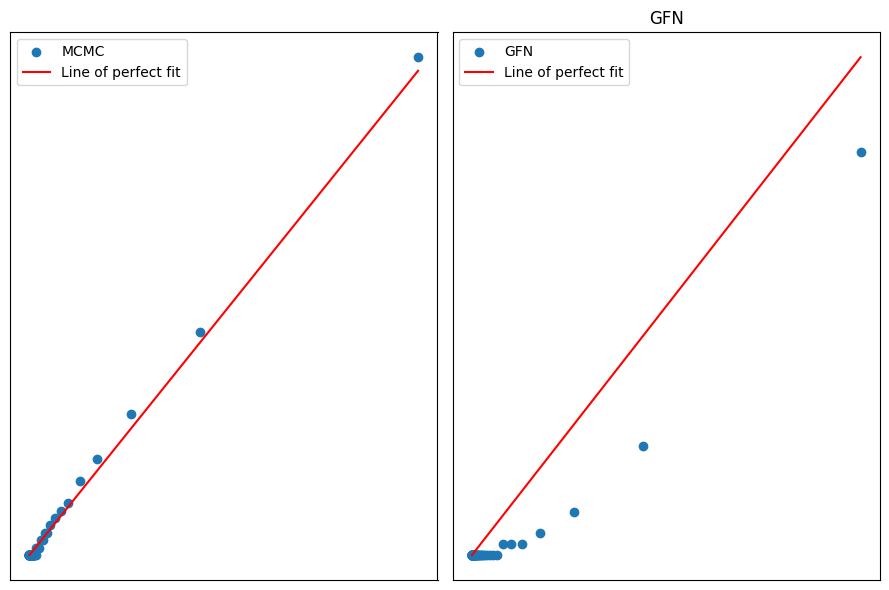

<Figure size 640x480 with 0 Axes>

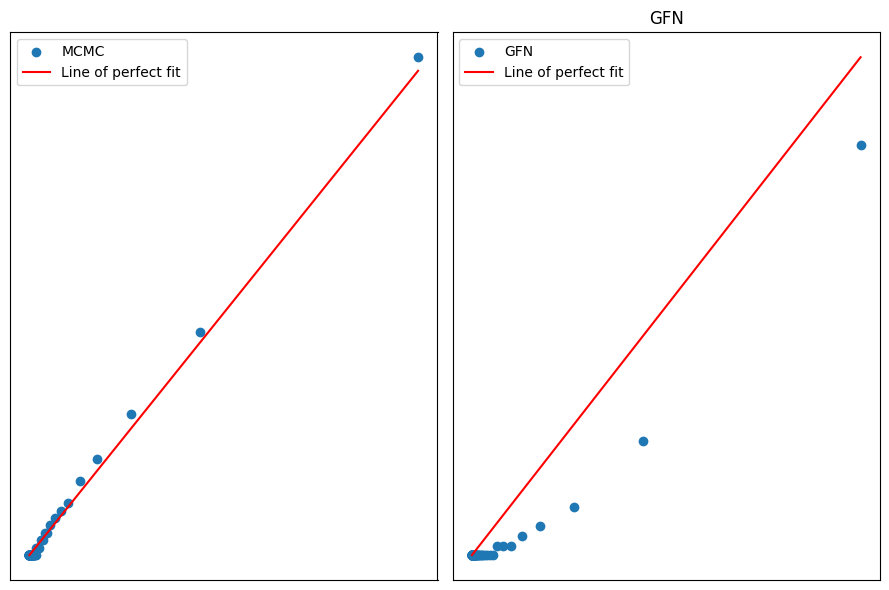

<Figure size 640x480 with 0 Axes>

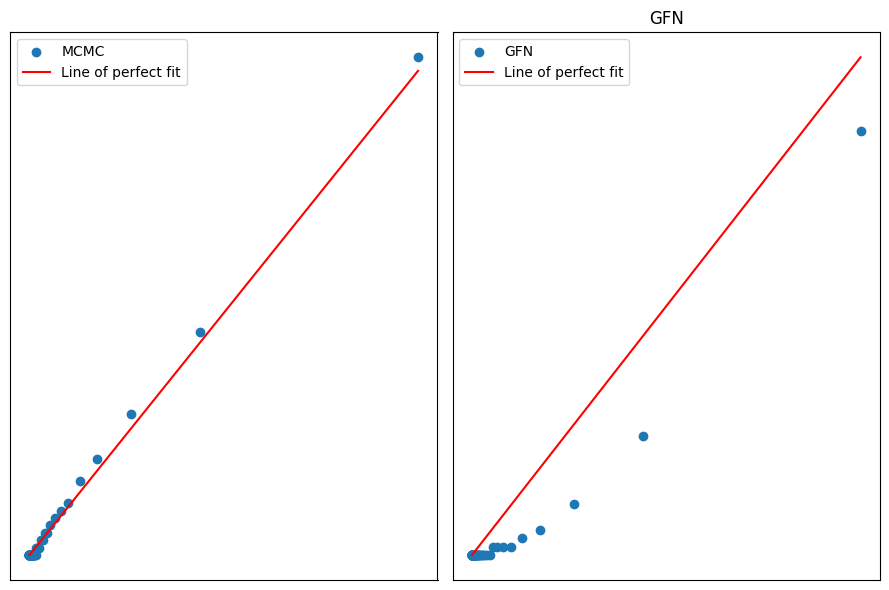

<Figure size 640x480 with 0 Axes>

In [121]:
for i in range(0, gfn_distributions_over_time.shape[0], int(gfn_distributions_over_time.shape[0]/10)):
    _, gfn_distributions_over_time_flattened_batch = get_distributions_over_time_flattened(grid_len, gfn_distributions_over_time, iteration=i)
    _, mcmc_distributions_over_time_flattened_batch = get_distributions_over_time_flattened(grid_len, mcmc_distributions_over_time, iteration=i)
    df_batch = pd.DataFrame({"Grid Coordinate": grid_coordinates_list, "Theoretical": theoretical_distributions_over_time_flattened, "MCMC": mcmc_distributions_over_time_flattened_batch, "GFN": gfn_distributions_over_time_flattened_batch})

    grid_coordinates_batch = df_batch[['Grid Coordinate']].values
    grid_coordinates_theoretical_batch = df_batch[["Theoretical"]].values
    grid_coordinates_MCMC_batch = df_batch[["MCMC"]].values
    grid_coordinates_GFN_batch = df_batch[["GFN"]].values

    df_pct_batch = pd.DataFrame()
    df_pct_batch['q_theoretical'] = np.percentile(grid_coordinates_theoretical_batch, range(100))
    df_pct_batch['q_MCMC'] = np.percentile(grid_coordinates_MCMC_batch, range(100))
    df_pct_batch['q_GFN'] = np.percentile(grid_coordinates_GFN_batch, range(100))

    fig_batch, axs_batch = plt.subplots(nrows=1, ncols=2, figsize=(9, 6), subplot_kw={'xticks': [], 'yticks': []})

    axs_batch[0].scatter(x='q_theoretical', y='q_MCMC', data=df_pct, label='MCMC')
    sns.lineplot(ax=axs_batch[0], x='q_theoretical', y='q_theoretical', data=df_pct_batch, color='r', label='Line of perfect fit')
    axs[0].set_title("MCMC")
    axs_batch[1].scatter(x='q_theoretical', y='q_GFN', data=df_pct_batch, label='GFN')
    sns.lineplot(ax=axs_batch[1], x='q_theoretical', y='q_theoretical', data=df_pct_batch, color='r', label='Line of perfect fit')
    axs_batch[1].set_title("GFN")

    plt.tight_layout()
    plt.show()
    plt.clf()

## Quantitative Analysis

For this part there are two ideas. One is to just compute the respective numbers fo the final cases of the empirical dsitributions. The other is (just for the GFN case), if we have data for each iteration (or batch of iterations) to plot the respective number for each iteration (batch).

In [6]:
# Assuming that we have mulitple dataframes: the final states (which is he same as in the previous section) and some for the intermediate states.

### T-test / Welch's t-test

In [65]:
if np.var(grid_coordinates_theoretical)/np.var(grid_coordinates_MCMC) < 4 or np.var(grid_coordinates_MCMC)/np.var(grid_coordinates_theoretical) < 4:
    equal_var_MCMC = True
else:
    equal_var_MCMC = False

stat_MCMC, p_value_MCMC = scipy.stats.ttest_ind(grid_coordinates_MCMC, grid_coordinates_theoretical, equal_var = equal_var_MCMC )
print(f"t-test for the MCMC: statistic={stat_MCMC}, p-value={p_value_MCMC}")

if np.var(grid_coordinates_theoretical)/np.var(grid_coordinates_GFN) < 4 or np.var(grid_coordinates_GFN)/np.var(grid_coordinates_theoretical) < 4:
    equal_var_GFN = True
else:
    equal_var_GFN = False


stat_GFN, p_value_GFN = scipy.stats.ttest_ind(grid_coordinates_GFN, grid_coordinates_theoretical, equal_var =equal_var_GFN)
print(f"t-test for the GFN: statistic={stat_GFN}, p-value={p_value_GFN}")

t-test for the MCMC: statistic=[1.81116973e-15], p-value=[1.]
t-test for the GFN: statistic=[1.44340827e-15], p-value=[1.]


In [66]:
# For the intermediate states:
data = []
batch = 1
for file in :
    df = pd.read_csv(file, delimiter=',')
    grid_coordianates_batch = df['Grid Coordinate'].values
    grid_coordinates_theoretical_batch = df.loc[df.Distribution == 'Theoretical', 'Grid Coordinate'].values
    grid_coordinates_GFN_batch = df.loc[df.Distribution=='GFN', 'Grid Coordinate'].values

    if np.var(grid_coordinates_theoretical_batch)/np.var(grid_coordinates_GFN_batch) > 4 or np.var(grid_coordinates_GFN_batch)/np.var(grid_coordinates_theoretical_batch) > 4:
        equal_var_GFN_batch = False
    else:
        equal_var_GFN_batch = True

    stat_GFN_batch, p_value_GFN_batch = scipy.stats.ttest_ind(grid_coordinates_GFN_batch, grid_coordinates_theoretical_batch, equal_var = equal_var_GFN_batch)
    data.append([batch, p_value_GFN])
    batch += 1

plt.plot(data=data, label="t-test for everyt batch of the GFN")
plt.show()
plt.clf()

SyntaxError: invalid syntax (2467471435.py, line 4)

### Standardized Mean Difference

In [73]:
# The one in the website is up to python 3.9, so I used another one, where the documentation is not htat good. I will fo the rest of the plots after we get the data.
table_one_MCMC = tableone.TableOne(df[["MCMC"]])
print(table_one_MCMC.tabulate(tablefmt="github"))

|             |             | Missing   | Overall       |
|-------------|-------------|-----------|---------------|
| n           |             |           | 371293        |
| MCMC, n (%) | 0.0         | 0         | 304676 (82.1) |
|             | 0.0001      |           | 7 (0.0)       |
|             | 0.000100625 |           | 10 (0.0)      |
|             | 0.00010125  |           | 10 (0.0)      |
|             | 0.000101875 |           | 10 (0.0)      |
|             | 0.0001025   |           | 8 (0.0)       |
|             | 0.000103125 |           | 12 (0.0)      |
|             | 0.00010375  |           | 9 (0.0)       |
|             | 0.000104375 |           | 7 (0.0)       |
|             | 0.000105    |           | 8 (0.0)       |
|             | 0.000105625 |           | 9 (0.0)       |
|             | 0.00010625  |           | 5 (0.0)       |
|             | 0.000106875 |           | 10 (0.0)      |
|             | 0.0001075   |           | 6 (0.0)       |
|             

In [74]:

table_one_GFN = tableone.TableOne(df[["GFN"]])
print(table_one_GFN.tabulate(tablefmt="github"))

|            |             | Missing   | Overall       |
|------------|-------------|-----------|---------------|
| n          |             |           | 371293        |
| GFN, n (%) | 0.0         | 0         | 334139 (90.0) |
|            | 0.0001      |           | 9 (0.0)       |
|            | 0.000100625 |           | 8 (0.0)       |
|            | 0.00010125  |           | 11 (0.0)      |
|            | 0.000101875 |           | 10 (0.0)      |
|            | 0.0001025   |           | 9 (0.0)       |
|            | 0.000103125 |           | 13 (0.0)      |
|            | 0.00010375  |           | 17 (0.0)      |
|            | 0.000104375 |           | 10 (0.0)      |
|            | 0.000105    |           | 10 (0.0)      |
|            | 0.000105625 |           | 6 (0.0)       |
|            | 0.00010625  |           | 14 (0.0)      |
|            | 0.000106875 |           | 9 (0.0)       |
|            | 0.0001075   |           | 7 (0.0)       |
|            | 0.000108125 |   

### Mann–Whitney U Test / Brunner-Munzel test

In [75]:
if equal_var_MCMC:
    stat_MCMC, p_value_MCMC = scipy.stats.mannwhitneyu(grid_coordinates_MCMC, grid_coordinates_theoretical)
    print(f" Mann–Whitney U Test: statistic={stat_MCMC}, p-value={p_value_MCMC}")
else:
    stat_MCMC, p_value_MCMC = scipy.stats.brunnermunzel(grid_coordinates_MCMC, grid_coordinates_theoretical)
    print(f"  Brunner-Munzel test: statistic={stat_MCMC}, p-value={p_value_MCMC}")

if equal_var_GFN:
    stat_GFN, p_value_GFN = scipy.stats.mannwhitneyu(grid_coordinates_GFN, grid_coordinates_theoretical)
    print(f" Mann–Whitney U Test: statistic={stat_GFN}, p-value={p_value_GFN}")
else:
    stat_GFN, p_value_GFN = scipy.stats.brunnermunzel(grid_coordinates_GFN, grid_coordinates_theoretical)
    print(f"  Brunner-Munzel test: statistic={stat_GFN}, p-value={p_value_GFN}")

 Mann–Whitney U Test: statistic=[2.24238298e+10], p-value=[0.]
 Mann–Whitney U Test: statistic=[1.22642664e+10], p-value=[0.]


In [ ]:
# For the intermediate states:
data = []
batch = 1
for file in :
    df = pd.read_csv(file, delimiter=',')
    grid_coordianates_batch = df['Grid Coordinate'].values
    grid_coordinates_theoretical_batch = df.loc[df.Distribution == 'Theoretical', 'Grid Coordinate'].values
    grid_coordinates_GFN_batch = df.loc[df.Distribution=='GFN', 'Grid Coordinate'].values

    if np.var(grid_coordinates_theoretical_batch)/np.var(grid_coordinates_GFN_batch) > 4 or np.var(grid_coordinates_GFN_batch)/np.var(grid_coordinates_theoretical_batch) > 4:
        equal_var_GFN_batch = False
    else:
        equal_var_GFN_batch = True

    if equal_var_GFN:
        stat_GFN, p_value_GFN = scipy.stats.mannwhitneyu(grid_coordinates_GFN_batch, grid_coordinates_theoretical)
        label = "Mann–Whitney U Test for each batch of the GFN"
    else:
        stat_GFN, p_value_GFN = scipy.stats.brunnermunzel(grid_coordinates_GFN_batch, grid_coordinates_theoretical)
        label = "Brunner-Munzel test for each batch of the GFN"
    data.append([batch, p_value_GFN])
    batch += 1

plt.plot(data=data, label=label)
plt.show()
plt.clf()

### Permutation Tests (NOT SURE IF WE NEED IT)

In [81]:
sample_stat_MCMC = np.mean(grid_coordinates_MCMC) - np.mean(grid_coordinates_theoretical)

stats = np.zeros(len(grid_coordinates_list))

for k in range(len(grid_coordinates_list)):
    labels = np.random.permutation((df[["MCMC"]]).values)
    stats[k] = np.mean(grid_coordinates[labels]) - np.mean(grid_coordinates[labels==False])
p_value = np.mean(stats > sample_stat_MCMC)

print(f"Permutation test for MCMC: p-value={p_value}")

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
plt.hist(stats, label='Permutation Statistics', bins=30)
plt.axvline(x=sample_stat_MCMC, c='r', ls='--', label='Sample Statistic')
plt.legend()
plt.xlabel('Income difference between MCMC and theoretical distribution')
plt.title('Permutation Test')
plt.show()
plt.clf()

In [ ]:
sample_stat_GFN = np.mean(grid_coordinates_GFN) - np.mean(grid_coordinates_theoretical)

stats = np.zeros(df.shape[0])

for k in range(df.shape[0]):
    labels = np.random.permutation((df['Distribution'] == 'GFN').values)
    stats[k] = np.mean(grid_coordinates[labels]) - np.mean(grid_coordinates[labels==False])
p_value = np.mean(stats > sample_stat_MCMC)

print(f"Permutation test for GFN: p-value={p_value}")

In [ ]:
plt.hist(stats, label='Permutation Statistics', bins=30)
plt.axvline(x=sample_stat_GFN, c='r', ls='--', label='Sample Statistic')
plt.legend()
plt.xlabel('Income difference between GFN and theoretical distribution')
plt.title('Permutation Test')
plt.show()
plt.clf()

### Chi-Squared Test

In [91]:
# Init dataframe
df_bins_MCMC = pd.DataFrame()

# Generate bins from control group
_, bins_MCMC = pd.qcut(grid_coordinates_theoretical.flatten(), q=10, retbins=True)
df_bins_MCMC['bin'] = pd.cut(grid_coordinates_MCMC.flatten(), bins=bins_MCMC).value_counts().index

# Apply bins to both groups
df_bins_MCMC['grid_coordinates_observed'] = pd.cut(grid_coordinates_theoretical.flatten(), bins=bins_MCMC).value_counts().values
df_bins_MCMC['grid_coordinates_MCMC_observed'] = pd.cut(grid_coordinates_MCMC.flatten(), bins=bins_MCMC).value_counts().values

# Compute expected frequency in the treatment group
df_bins_MCMC['grid_coordinates_MCMC_expected'] = df_bins_MCMC['grid_coordinates_observed'] / np.sum(df_bins_MCMC['grid_coordinates_observed']) * np.sum(df_bins_MCMC['grid_coordinates_MCMC_observed'])

df_bins_MCMC

stat_MCMC, p_value_MCMC = scipy.stats.chisquare(df_bins_MCMC['grid_coordinates_MCMC_observed'], df_bins_MCMC['grid_coordinates_MCMC_expected'])
print(f"Chi-squared Test: statistic={stat_MCMC}, p-value={p_value_MCMC}")

Chi-squared Test: statistic=288860.33977046993, p-value=0.0


In [92]:
# Init dataframe
df_bins_GFN = pd.DataFrame()

# Generate bins from control group
_, bins_GFN = pd.qcut(grid_coordinates_theoretical.flatten(), q=10, retbins=True)
df_bins_GFN['bin'] = pd.cut(grid_coordinates_GFN.flatten(), bins=bins_GFN).value_counts().index

# Apply bins to both groups
df_bins_GFN['grid_coordinates_observed'] = pd.cut(grid_coordinates_theoretical.flatten(), bins=bins_GFN).value_counts().values
df_bins_GFN['grid_coordinates_GFN_observed'] = pd.cut(grid_coordinates_GFN.flatten(), bins=bins_GFN).value_counts().values

# Compute expected frequency in the treatment group
df_bins_GFN['grid_coordinates_GFN_expected'] = df_bins_GFN['grid_coordinates_observed'] / np.sum(df_bins_GFN['grid_coordinates_observed']) * np.sum(df_bins_GFN['grid_coordinates_GFN_observed'])

df_bins_GFN

stat_GFN, p_value_GFN = scipy.stats.chisquare(df_bins_GFN['grid_coordinates_GFN_observed'], df_bins_GFN['grid_coordinates_GFN_expected'])
print(f"Chi-squared Test: statistic={stat_GFN}, p-value={p_value_GFN}")

Chi-squared Test: statistic=148990.10480554646, p-value=0.0


### Kolmogorov-Smirnov Test

In [97]:
df_ks_MCMC = pd.DataFrame()
df_ks_MCMC['MCMC'] = np.sort(df['MCMC'].unique())
df_ks_MCMC['F_theoretical'] = df_ks_MCMC['MCMC'].apply(lambda x: np.mean(grid_coordinates_theoretical<=x))
df_ks_MCMC['F_MCMC'] = df_ks_MCMC['MCMC'].apply(lambda x: np.mean(grid_coordinates_MCMC<=x))
df_ks_MCMC.head()

,MCMC,F_theoretical,F_MCMC
0,0.000000e+00,0.000000,0.820581
1,6.250000e-07,0.815275,0.861772
2,1.250000e-06,0.873348,0.887025
3,1.875000e-06,0.900768,0.904496
4,2.500000e-06,0.917090,0.917265


In [98]:
# Point where the absolute distance between the cumulative distribution functions is largest.
k_MCMC = np.argmax( np.abs(df_ks_MCMC['F_theoretical'] - df_ks_MCMC['F_MCMC']))
ks_stat_MCMC = np.abs(df_ks_MCMC['F_MCMC'][k_MCMC] - df_ks_MCMC['F_theoretical'][k_MCMC])

ValueError: x and y must have same first dimension, but have shapes (1,) and (803,)

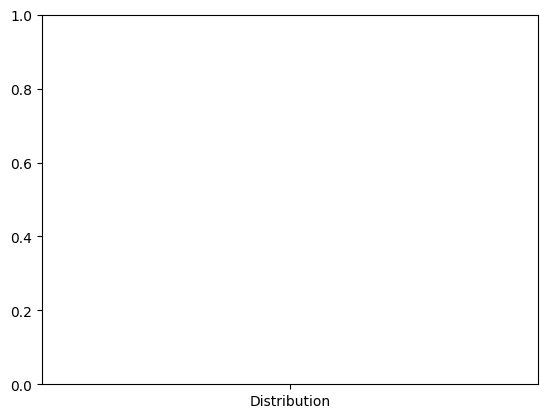

In [100]:
y_MCMC = (df_ks_MCMC['F_MCMC'][k_MCMC] + df_ks_MCMC['F_theoretical'][k_MCMC])/2
plt.plot('Distribution', 'F_theoretical', data=df_ks_MCMC, label='Theoretical')
plt.plot('Distribution', 'F_MCMC', data=df_ks_MCMC, label='MCMC')
plt.errorbar(x=df_ks_MCMC['MCMC'][k_MCMC], y=y_MCMC, yerr=ks_stat_MCMC/2, color='k',
             capsize=5, mew=3, label=f"Test statistic: {ks_stat_MCMC}")
plt.legend(loc='center right')
plt.title("Kolmogorov-Smirnov Test for MCMC")

In [ ]:
stat_MCMC, p_value_MCMC = scipy.stats.kstest(grid_coordinates_MCMC, grid_coordinates_theoretical)
print(f" Kolmogorov-Smirnov Test for MCMC: statistic={stat_MCMC}, p-value={p_value_MCMC}")

In [ ]:
df_ks_GFN = pd.DataFrame()
df_ks_GFN['Distribution'] = np.sort(df['Distribution'].unique())
df_ks_GFN['F_theoretical'] = df_ks_GFN['Distribution'].apply(lambda x: np.mean(grid_coordinates_theoretical<=x))
df_ks_GFN['F_GFN'] = df_ks_GFN['Distribution'].apply(lambda x: np.mean(grid_coordinates_GFN<=x))
df_ks_GFN.head()

In [ ]:
# Point where the absolute distance between the cumulative distribution functions is largest.
k_GFN = np.argmax( np.abs(df_ks_GFN['F_theoretical'] - df_ks_GFN['F_GFN']))
ks_stat_GFN = np.abs(df_ks_GFN['F_GFN'][k_GFN] - df_ks_GFN['F_theoretical'][k_GFN])

In [ ]:
y_GFN = (df_ks_GFN['F_GFN'][k_GFN] + df_ks_GFN['F_theoretical'][k_GFN])/2
plt.plot('Distribution', 'F_theoretical', data=df_ks_GFN, label='Theoretical')
plt.plot('Distribution', 'F_GFN', data=df_ks_GFN, label='GFN')
plt.errorbar(x=df_ks_GFN['Distribution'][k_GFN], y=y_GFN, yerr=ks_stat_GFN/2, color='k',
             capsize=5, mew=3, label=f"Test statistic: {ks_stat_GFN}")
plt.legend(loc='center right')
plt.title("Kolmogorov-Smirnov Test for GFN")

In [ ]:
stat_GFN, p_value_GFN = scipy.stats.kstest(grid_coordinates_GFN, grid_coordinates_theoretical)
print(f" Kolmogorov-Smirnov Test for MCMC: statistic={stat_GFN}, p-value={p_value_GFN}")

# Lilliefors test 

In [ ]:
stat_MCMC, p_value_MCMC = statsmodels.stats.diagnostic.lilliefors(grid_coordinates_MCMC, dist="norm")
print(f" Lilliefors Test for MCMC: statistic={stat_MCMC}, p-value={p_value_MCMC}")

In [ ]:
stat_GFN, p_value_GFN = statsmodels.stats.diagnostic.lilliefors(grid_coordinates_GFN, dist="norm")
print(f" Lilliefors Test GFN: statistic={stat_GFN}, p-value={p_value_GFN}")

 # Anderson-Darling test

In [ ]:
stat_MCMC, p_value_MCMC = scipy.stats.anderson(grid_coordinates_MCMC, dist="norm")
print(f" Anderson-Darling Test for MCMC: statistic={stat_MCMC}, p-value={p_value_MCMC}")

In [ ]:
stat_GFN, p_value_GFN = scipy.stats.anderson(grid_coordinates_GFN, dist="norm")
print(f" Anderson-Darling Test GFN: statistic={stat_GFN}, p-value={p_value_GFN}")

# Cramér-von Mises test

In [ ]:
stat_MCMC, p_value_MCMC = scipy.stats.cramervonmises(grid_coordinates_MCMC, grid_coordinates_theoretical)
print(f" Cramér-von Mises Test for MCMC: statistic={stat_MCMC}, p-value={p_value_MCMC}")

In [ ]:
stat_GFN, p_value_GFN = scipy.stats.cramervonmises(grid_coordinates_GFN, grid_coordinates_theoretical)
print(f" Cramér-von Mises Test for GFN: statistic={stat_GFN}, p-value={p_value_GFN}")